In [1]:
import numpy as np
import matplotlib.pylab as plt
from scipy.spatial import distance
from IPython.display import HTML
from copy import copy, deepcopy

In [16]:
def generate_points(n_points, radius):
    angles = np.random.uniform(0, 2 * np.pi, n_points)  # Random angles
    r = np.sqrt(np.random.uniform(0, 1, n_points)) * radius  # Random radius with correct distribution
    x = r * np.cos(angles)
    y = r * np.sin(angles)
    return np.column_stack((x, y))  # Return as Nx2 array

def move_point(point, angle, distance):
    # Convert angle to radians
    angle_rad = np.radians(angle)

    # Calculate the movement vector components
    dx = distance * np.cos(angle_rad)
    dy = distance * np.sin(angle_rad)

    # Create a movement vector for all points
    displacement_vector = np.array([dx, dy])

    # Displace the points
    displaced_point = point + displacement_vector

    return displaced_point.astype(np.double)


def circle_line_intersection(circle_center, radius, point1, point2):
    h, k = circle_center
    x1, y1 = point1
    x2, y2 = point2

    # Calculate slope (m) and intercept (b) of the line
    if x2 - x1 == 0:  # vertical line case
        return []  # A vertical line will not intersect unless it's also at the circle's horizontal level

    m = (y2 - y1) / (x2 - x1)
    b = y1 - m * x1

    # Coefficients of the quadratic equation Ax^2 + Bx + C = 0
    A = 1 + m**2
    B = 2 * (m * (b - k) - h)
    C = (h**2 + (b - k)**2 - radius**2)

    # Calculate the discriminant
    D = B**2 - 4 * A * C

    intersection_points = []

    if D >= 0:  # There are intersections
        # Two possible intersection points if D > 0, one if D = 0
        sqrt_D = np.sqrt(D)

        # Compute both x-coordinates
        x_intersect1 = (-B + sqrt_D) / (2 * A)
        y_intersect1 = m * x_intersect1 + b
        intersection_points.append((x_intersect1, y_intersect1))

        if D > 0:  # Only compute the second intersection point if D > 0
            x_intersect2 = (-B - sqrt_D) / (2 * A)
            y_intersect2 = m * x_intersect2 + b
            intersection_points.append((x_intersect2, y_intersect2))

    return np.array(intersection_points).astype(np.double)


def point_inside_circle(circle_center, radius, point):
    h, k = circle_center
    x, y = point
    
    # Calculate the squared distance from the point to the circle center
    dist_squared = (x - h) ** 2 + (y - k) ** 2
    radius_squared = radius ** 2

    # Check if the point is inside or on the circle
    return dist_squared <= radius_squared

def points_inside_circle(circle_center, radius, points):
    points = np.array(points)
    h, k = circle_center
    x, y = np.hsplit(points, 2)
    
    # Calculate the squared distance from the point to the circle center
    dist_squared = (x - h) ** 2 + (y - k) ** 2
    radius_squared = radius ** 2

    # Check if the point is inside or on the circle
    result = dist_squared <= radius_squared
    return result.flatten()


def vector_points(point1, point2):
    x1, y1 = point1
    x2, y2 = point2

    # Calculate the vector components
    dx = x2 - x1
    dy = y2 - y1

    return np.array([dx, dy]).astype(np.double)


def displace_points(circle_center, radius, angle, dist, points):    
    points_moved = move_point(points, angle, dist)
    points_out = ~points_inside_circle(circle_center, radius, points_moved)
    points_out_ix = np.arange(points.shape[0])[points_out]
    points_moved_copy = deepcopy(points_moved)
    for p_ix in points_out_ix:
        point = points[p_ix]
        point_moved = points_moved[p_ix]
        inters_vector_line = circle_line_intersection(circle_center, radius, point, point_moved)
        inters_0, inters_1 = inters_vector_line
        inters = [inters_0, inters_1]
        dist_ = [distance.euclidean(i, point_moved) for i in inters]
        new_orig = inters[np.argmax(dist_)]
        left_disp_orig = inters[np.argmin(dist_)]
        left_disp_vec = vector_points(left_disp_orig, point_moved)
        point_moved_new = new_orig + left_disp_vec
        points_moved_copy[p_ix] = point_moved_new
    return points_moved, points_moved_copy, points_out


In [17]:
circle_diameter = 14
radius = circle_diameter/2

In [18]:
point = [2.5, 5.0]
point_moved = move_point(point, 0, 4)
inters_vector_line = circle_line_intersection([0,0], radius, point, point_moved)
inters_0, inters_1 = inters_vector_line
inters = [inters_0, inters_1]
point_moved_out = ~point_inside_circle([0,0], radius, point_moved)

if point_moved_out:
    dist_ = [distance.euclidean(i, point_moved) for i in inters]
    new_orig = inters[np.argmax(dist_)]
    left_disp_orig = inters[np.argmin(dist_)]
    left_disp_vec = vector_points(left_disp_orig, point_moved)
    point_moved_new = new_orig + left_disp_vec

In [19]:
n_points = 500
points = generate_points(n_points, radius)

In [20]:
points_moved = move_point(points, 180, 2)
points_out = ~points_inside_circle([0,0], radius, points_moved)

(-10.0, 10.0)

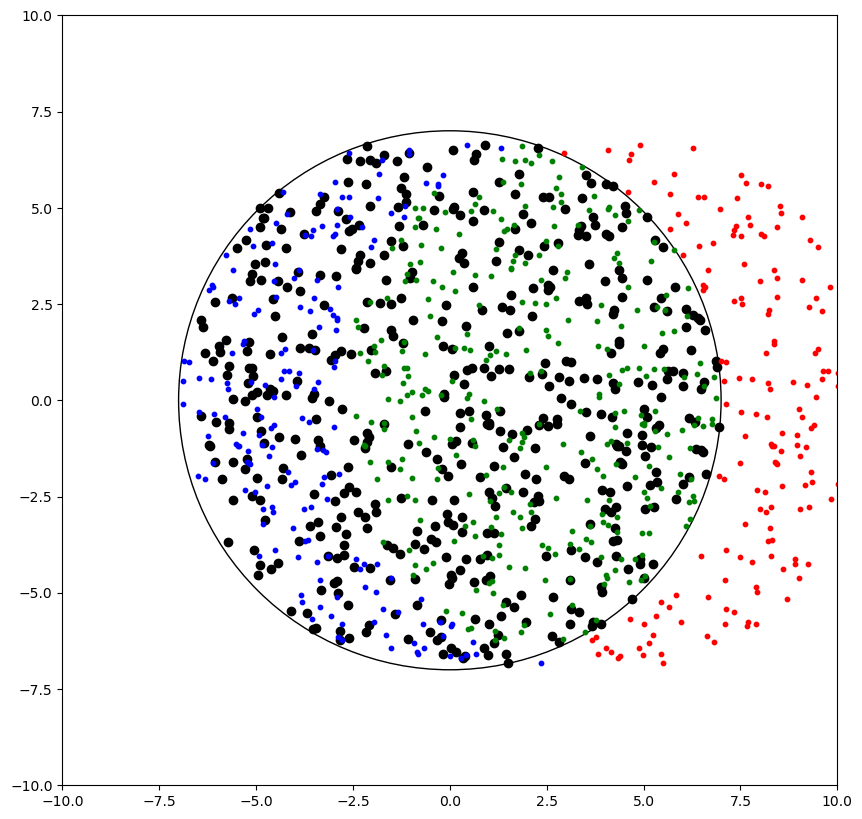

In [23]:
pm, pm_c, po_map = displace_points([0,0], radius, 0, 4, points)

f, ax = plt.subplots(1,1, figsize=(10,10))

circle = plt.Circle(
    (0, 0), radius=circle_diameter/2, edgecolor="black",
    lw=1, facecolor="none"
)

ax.add_patch(circle)
ax.scatter(points[:,0], points[:,1], c="black")
ax.scatter(pm[:,0][~po_map], pm[:,1][~po_map], c="green", s=10)
ax.scatter(pm[:,0][po_map], pm[:,1][po_map], c="red", s=10)
ax.scatter(pm_c[:,0][po_map], pm_c[:,1][po_map], c="blue", s=10)
ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)

